In [54]:
import tensorflow as tf
from sklearn.metrics import classification_report
import seaborn as sns;sns.set()
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow.keras as K
from skimage.transform import resize
from tensorflow.keras.models import Model
import cv2

### Cargamos los mejores modelos serializados

Los mejores modelos de todos los candidatos fueron 2:

* Modelo usando transfer learning DenseNet169 con balanceo de Penalizacion de clases
* Modelo usando tranfer learning sobre DenseNet169 con balanceo de perdida focal

* Primero cargamos la funcion personalizada usada para la perdida focal, esta es importante para realizar la evaluacion del modelo

In [2]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]
        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [3]:
path_model_weighted="../input/modelosfinales/tranferlearning_densenet169_with_balanced_focal_loss_3_class_equalized_wgt.h5"
path_model_focal="../input/modelosfinales/tranferlearning_densenet169_with_balanced_focal_loss_3_class_equalized.h5"
#modelo con penalizacion de clases para el balanceo
model_transfer_class_weight=tf.keras.models.load_model(path_model_weighted)
#modelo con balanceo usando perdida focal
model_transfer_focal_loss=tf.keras.models.load_model(path_model_focal, custom_objects={'focal_loss_fixed': focal_loss()})

In [4]:
model_transfer_class_weight.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
flatten_1 (Flatten)          (None, 106496)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 106496)            425984    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               27263232  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024

In [5]:
model_transfer_focal_loss.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
flatten_1 (Flatten)          (None, 106496)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 106496)            425984    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               27263232  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024

### Cargamos el flujo de datos de TEST

* A traves de la libreria

In [6]:
path_test="../input/datasettestcovid19/test"
IMAGE_SIZE=(256,256)
test_datagen=ImageDataGenerator(rescale=1.0/255)
test_generator=test_datagen.flow_from_directory(
            path_test,
            target_size=IMAGE_SIZE,
            batch_size=32,
            shuffle=False,
            class_mode="categorical"
)

Found 4233 images belonging to 3 classes.


In [7]:
test_generator.class_indices

{'COVID': 0, 'Enfermedades Pulmonares No COVID19': 1, 'Normal': 2}

In [8]:
test_generator.reset()

In [9]:
model_transfer_class_weight.evaluate(test_generator)

133/133 [==============================] - 36s 201ms/step - loss: 0.2244 - accuracy: 0.9213 - recall: 0.9178


[0.22444237768650055, 0.9213323593139648, 0.9177888035774231]

In [10]:
test_generator.reset()

In [11]:
model_transfer_focal_loss.evaluate(test_generator)

133/133 [==============================] - 19s 120ms/step - loss: 0.2670 - accuracy: 0.9242 - recall: 0.9187


[0.26700618863105774, 0.924167275428772, 0.9187337756156921]

* Y efectivamente el modelo que logro una mayor precision fue el Transferencia de informacion con un accuracy de 92.42% de aciertos en datos **NUNCA ANTES VISTOS**.

Elaboremos su matriz de clasificación.

In [15]:
test_generator.reset()

In [16]:
y_true=test_generator.classes
predictions=model_transfer_focal_loss.predict(test_generator)
y_pred=np.argmax(predictions,axis=1)

In [20]:
test_generator.class_indices

{'COVID': 0, 'Enfermedades Pulmonares No COVID19': 1, 'Normal': 2}

#### Matriz de confusion

En esta tendremos una version mas realista de cada clase mal predecida.

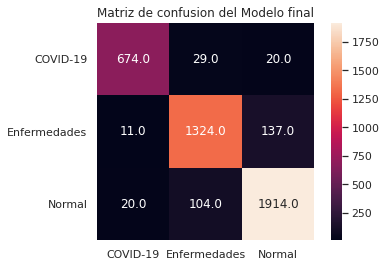

In [23]:
target_names={"COVID-19":0,"Enfermedades":1,"Normal":2}#test_generator.class_indices
mat=confusion_matrix(y_true,y_pred)


sns.heatmap(mat,annot=True,fmt="0.1f",square=True,xticklabels=target_names,yticklabels=target_names)
plt.title("Matriz de confusion del Modelo final")
plt.show()

* **Reporte de clasificacion**: Aqui tendremos un reporte sobre la precision en las predicciones de cada clase.

In [24]:
report=classification_report(y_true,y_pred,target_names=target_names)
print(report)

              precision    recall  f1-score   support

    COVID-19       0.96      0.93      0.94       723
Enfermedades       0.91      0.90      0.90      1472
      Normal       0.92      0.94      0.93      2038

    accuracy                           0.92      4233
   macro avg       0.93      0.92      0.93      4233
weighted avg       0.92      0.92      0.92      4233



## INTERPRETABILIDAD DEL MODELO

* A veces la pregunta suele ser porque modelo predice lo que predice, para ello usaremos el metodo de activacion en capas llamado CamGrad que nos muestra un mapa de calor sobre las partes donde el modelo ha tenido mayor actividad sobre la imagen a clasificar, esto nos puede ayudar a determinar  que lugares de una radiografia son determinantes para predecir si una radiografia de rayos-X es de COVID-19

El codigo usado en el siguiente espacio pertenece a la libreria Keras

In [3]:
path_model_focal="../Models/tranferlearning_densenet169_with_balanced_focal_loss_3_class_equalized.h5"
model_transfer_focal_loss=tf.keras.models.load_model(path_model_focal, custom_objects={'focal_loss_fixed': focal_loss()})

In [34]:
model_transfer_focal_loss.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
flatten_1 (Flatten)          (None, 106496)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 106496)            425984    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               27263232  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024

* Una vez obtenido el modelo de transfer learning. Necesitamos la imagen preprocesada

In [24]:
tf.keras.Model

tensorflow.python.keras.engine.training.Model

In [83]:
import random
import os
def get_random_path(origin):
    return random.sample([ arch.path for arch in os.scandir(origin)],1)[0]
def preprocess_image(img_path,target_size=None):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    #array=np.expand_dims(array,axis=0)
    array=array*1.0/255
    return array

img_path=get_random_path("../Datasets/test/COVID")
img_array=preprocess_image(img_path,target_size=(256,256))

In [90]:
print("La imagen fue extraida de:",img_path)

La imagen fue extraida de: ../Datasets/test/COVID\COVID-103.png


Implementacion de algoritmo de GradCAM

In [53]:
#aqui obtenemos el modelo original del transfer learning
def get_transfer_model(model):
    model_transfer=None
    for layer in model.layers:
        if isinstance(layer,tf.keras.Model):
            model_transfer=layer
            break
    return model_transfer

def get_last_conv_layer(model):
    for layer in model.layers[::-1]:
        if isinstance(layer,K.layers.Conv2D):
            return layer
    return None

In [97]:
def VizGradCAM(model, image, interpolant=0.6, return_gradcam=True):
   
    # Sanity Check
    
    #if interpolant < 0 or interpolant >1:
    #    print("Heatmap Interpolation Must Be Between 0 - 1")
    #   return None
    
    transfer_model=get_transfer_model(model)
   
    last_conv_layer = get_last_conv_layer(transfer_model)

    target_layer = transfer_model.get_layer(last_conv_layer.name)

    original_img = image
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)

    # Obtain Prediction Index
    prediction_idx = np.argmax(prediction)
    
    # Compute Gradient of Top Predicted Class
    with tf.GradientTape() as tape:
        gradient_model = Model([transfer_model.inputs], [target_layer.output, transfer_model.output])
        conv2d_out, prediction = gradient_model(img)
        # Obtain the Prediction Loss
        loss = prediction[:, prediction_idx]

    # Gradient() computes the gradient using operations recorded
    # in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    # Obtain the Output from Shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    # Obtain Depthwise Mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # Create a 7x7 Map for Aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    # Multiply Weights with Every Layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to Size of Image
    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    # Ensure No Negative Numbers
    activation_map = np.maximum(activation_map, 0)

    # Convert Class Activation Map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
    activation_map = np.uint8(255 * activation_map)

    # Convert to Heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Enlarge Plot
    plt.rcParams["figure.dpi"] = 100

    if return_gradcam == True:
        return np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
        
        #plt.savefig("./grad_cam_image.png")
    else:
        return cvt_heatmap


In [117]:
def compare_gradcam(model,path_image):
    fig,(ax1,ax2)=plt.subplots(1,2)
    fig.set_size_inches(10,10)
    array_image=preprocess_image(path_image,target_size=(256,256))
    im=plt.imread(path_image)
    ax1.imshow(im,cmap="bone")
    ax1.set_title("Radiografia con COVID-19")
    ax1.axis(False)
    array_gradcam=VizGradCAM(model, img_array, return_gradcam=True, interpolant=0.35)
    ax2.imshow(array_gradcam)
    ax2.set_title("Mayor actividad del Modelo")
    ax2.axis(False)

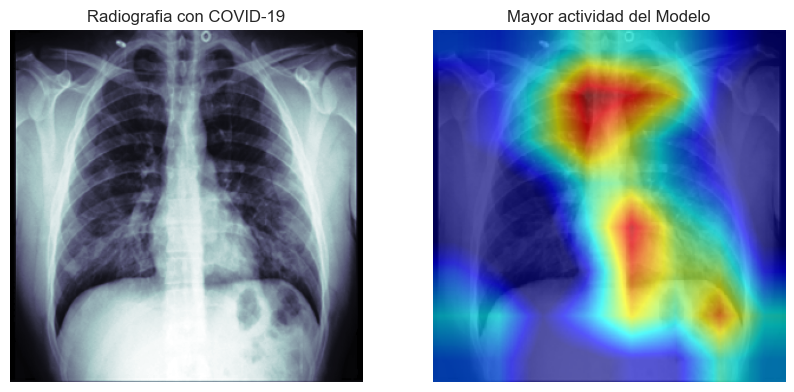

In [118]:
compare_gradcam(model_transfer_focal_loss,img_path)

* Observamos que el modelo tiene mayor actividad sobre zonas centrales en los pulmones, esto indica cierto factor determinante para escoger COVID-19

## CONCLUSIONES:

Este modelo posee una precision del 92% sobre datos nunca antes vistos, a su vez podemos afirmar que clasifica correctamente como:

- COVID-19 el 96% de los casos
- Enfermedades pulmonares el 91% de los casos
- Radiografias normales el 92% de los casos

El siguiente paso en la metodologia CRISP-DM es el despliegue del modelo a produccion.